In [86]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sheerwater.data import chirps, imerg
from sheerwater.forecasts import graphcast, ecmwf_ifs_er_debiased
from sheerwater.metrics import metric
from sheerwater.utils import apply_mask

In [44]:
start_time = "2019-01-01"
end_time = "2019-12-31"

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Found cache for imerg/agg_days_7/end_time_2019-12-31/grid_global0_25/mask_lsm/region_africa/start_time_2019-01-01/variable_precip with backend zarr in local cache
CPU times: user 177 ms, sys: 95.1 ms, total: 273 ms
Wall time: 190 ms


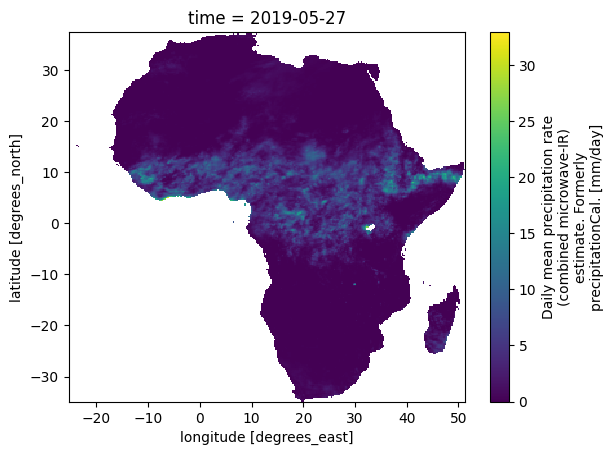

In [46]:
%%time
ds = imerg(start_time, end_time, agg_days=7, grid='global0_25', mask="lsm", region="africa", cache_mode='local')
ds.precip.sel(time="2019-05-27").plot(x='lon')

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Found cache for imerg/agg_days_7/end_time_2019-12-31/grid_global1_5/mask_lsm/region_africa/start_time_2019-01-01/variable_precip with backend zarr in local cache
CPU times: user 40.5 ms, sys: 49.5 ms, total: 90 ms
Wall time: 110 ms


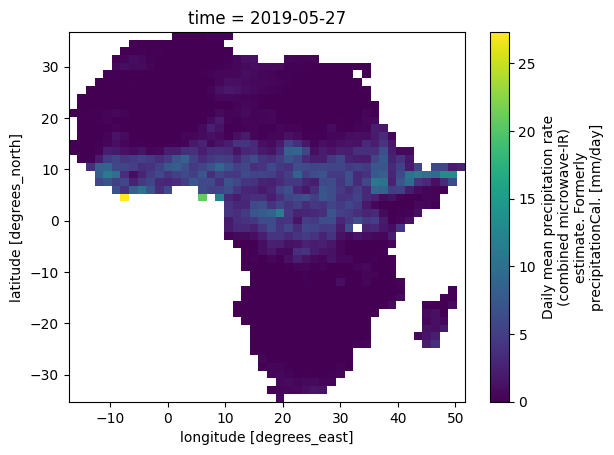

In [47]:
%%time
ds_truth = imerg(start_time, end_time, agg_days=7, grid='global1_5', mask="lsm", region="africa", cache_mode='local')
ds_truth.precip.sel(time="2019-05-27").plot(x='lon')

In [49]:
%%time
ds_fcst = ecmwf_ifs_er_debiased(start_time, end_time, grid='global1_5', agg_days=7, mask="lsm", region="africa", cache_mode='local')
ds_fcst

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Found cache for ecmwf_ifs_er_debiased/agg_days_7/end_time_2019-12-31/grid_global1_5/mask_lsm/prob_type_deterministic/region_africa/start_time_2019-01-01/variable_precip with backend zarr in local cache
CPU times: user 33.8 ms, sys: 24.1 ms, total: 57.9 ms
Wall time: 56.3 ms


<xarray.Dataset> Size: 7MB
Dimensions:               (lat: 48, lon: 46, time: 140, prediction_timedelta: 6)
Coordinates:
  * lat                   (lat) float32 192B -34.5 -33.0 -31.5 ... 34.5 36.0
  * lon                   (lon) float32 184B -16.5 -15.0 -13.5 ... 49.5 51.0
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 48B 0 days ....
  * time                  (time) datetime64[ns] 1kB 2018-11-19 ... 2020-03-19
Data variables:
    precip                (lat, lon, time, prediction_timedelta) float32 7MB dask.array<chunksize=(48, 46, 140, 6), meta=np.ndarray>
Attributes:
    agg_days:    7.0
    end_time:    2020-02-15
    grid:        global1_5
    mask:        lsm
    prob_type:   deterministic
    region:      africa
    start_time:  2018-11-16
    units:       mm / day
    variable:    precip

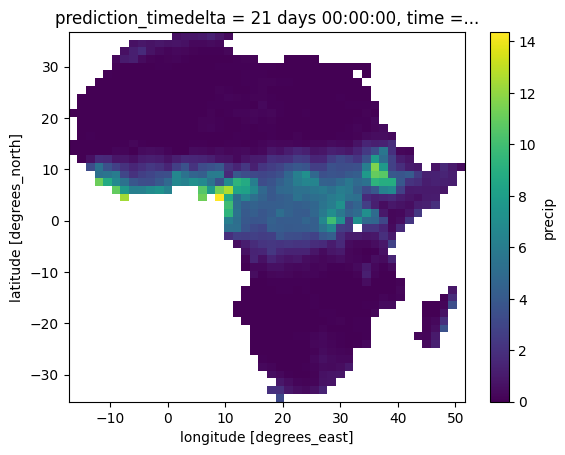

In [54]:
lead = np.timedelta64(21, 'D')
ds_fcst.precip.sel(time="2019-05-27", prediction_timedelta=lead).plot(x='lon')

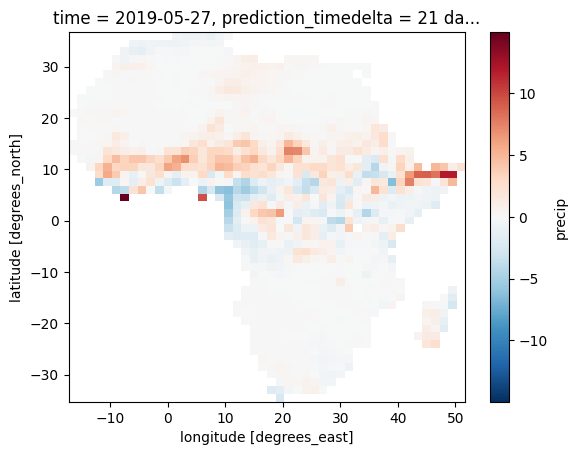

In [55]:
error = ds_truth - ds_fcst
error.isel(prediction_timedelta=3).sel(time="2019-05-27").precip.plot(x='lon')

In [77]:
mae_computed = np.abs(error).mean(dim=['lat', 'lon', 'time'])
print("Unweighted error of", mae_computed.precip.values, "mm / day of rainfall")

Unweighted error of [0.91323316 0.9863455  1.0368865  1.0531076  1.0600818  1.0663426 ] mm / day of rainfall


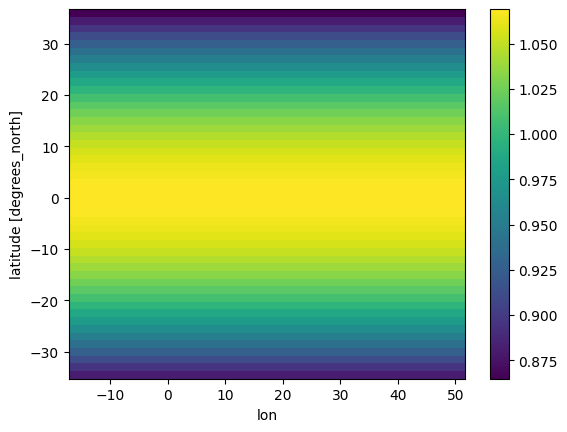

In [66]:
weights.plot(x='lon')

In [71]:
46*48

2208

In [85]:
weights

<xarray.DataArray (lon: 46, lat: 48)> Size: 9kB
array([[0.8810059 , 0.8965563 , 0.91148853, ..., 0.8965563 , 0.8810059 ,
        0.8648567 ],
       [0.8810059 , 0.8965563 , 0.91148853, ..., 0.8965563 , 0.8810059 ,
        0.8648567 ],
       [0.8810059 , 0.8965563 , 0.91148853, ..., 0.8965563 , 0.8810059 ,
        0.8648567 ],
       ...,
       [0.8810059 , 0.8965563 , 0.91148853, ..., 0.8965563 , 0.8810059 ,
        0.8648567 ],
       [0.8810059 , 0.8965563 , 0.91148853, ..., 0.8965563 , 0.8810059 ,
        0.8648567 ],
       [0.8810059 , 0.8965563 , 0.91148853, ..., 0.8965563 , 0.8810059 ,
        0.8648567 ]], shape=(46, 48), dtype=float32)
Coordinates:
  * lon      (lon) float32 184B -16.5 -15.0 -13.5 -12.0 ... 46.5 48.0 49.5 51.0
  * lat      (lat) float32 192B -34.5 -33.0 -31.5 -30.0 ... 31.5 33.0 34.5 36.0

In [95]:
weights

<xarray.Dataset> Size: 6MB
Dimensions:               (lon: 46, lat: 48, time: 104, prediction_timedelta: 6)
Coordinates:
  * lon                   (lon) float32 184B -16.5 -15.0 -13.5 ... 49.5 51.0
  * lat                   (lat) float32 192B -34.5 -33.0 -31.5 ... 34.5 36.0
  * time                  (time) datetime64[ns] 832B 2019-01-03 ... 2019-12-30
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 48B 0 days ....
Data variables:
    precip                (lon, lat, time, prediction_timedelta) float32 6MB dask.array<chunksize=(46, 48, 104, 6), meta=np.ndarray>

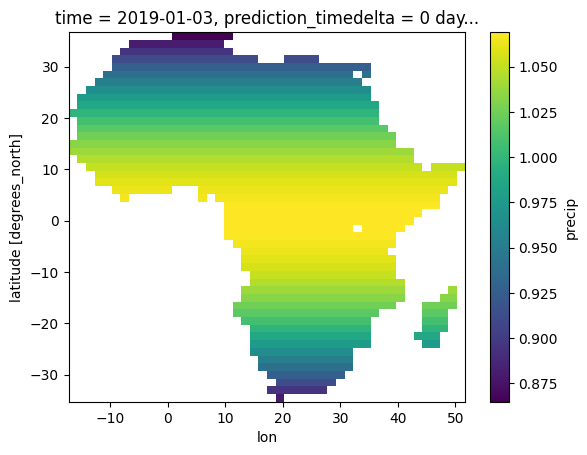

In [98]:
from sheerwater.utils import latitude_weights
weights = latitude_weights(error)
weights = weights.where(error.notnull(), np.nan, drop=False)
weights.precip.isel(time=0, prediction_timedelta=0).plot(x='lon')

In [97]:
mae_weighted = (((np.abs(error) * weights).sum(dim=['lat', 'lon'])) / weights.sum(dim=['lat', 'lon'])).mean(dim='time')
print("Unweighted error of", mae_weighted.precip.values, "mm / day of rainfall")

Unweighted error of [0.9373426 1.0099219 1.0608622 1.0774331 1.0843532 1.0908203] mm / day of rainfall


In [87]:
mae_sheerwater = metric(start_time, end_time, "precip", agg_days=7, 
                        forecast="ecmwf_ifs_er_debiased",
                        truth="imerg",
                        metric_name="mae",
                        grid="global1_5",
                        mask="lsm",
                        region="africa",
                        cache_mode='local')

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Found cache for metric/agg_days_7/end_time_2019-12-31/forecast_ecmwf_ifs_er_debiased/grid_global1_5/mask_lsm/metric_name_mae/region_africa/space_grouping_None/spatial_False/start_time_2019-01-01/time_grouping_None/truth_imerg/variable_precip with backend zarr in local cache


In [89]:
mae_sheerwater.mae.values

array([0.93734235, 1.0099201 , 1.0608618 , 1.0774329 , 1.0843537 ,
       1.0908198 ], dtype=float32)

In [90]:
print("Unweighted error of", mae_computed.precip.values, "mm / day of rainfall")

Unweighted error of [0.91323316 0.9863455  1.0368865  1.0531076  1.0600818  1.0663426 ] mm / day of rainfall
